<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Reinforcement Learning for Finance

**Chapter 04 — Simulated Data (Keras 3 with PyTorch Backend)**

© Dr. Yves J. Hilpisch

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

**Adapted for Keras 3 API with PyTorch backend**

## Chapter 4: Data Augmentation

This chapter addresses a key limitation from Chapter 3:
**"Training data limited to a single, static time series"**

### Two Data Augmentation Approaches:

1. **NoisyData**: Add white noise to existing financial data
   - Simple and effective
   - Creates variations of historical data
   - Prevents overfitting to exact sequence

2. **Simulation**: Generate synthetic data using financial models
   - Mean-reverting processes (Ornstein-Uhlenbeck)
   - Unlimited training scenarios
   - Controllable market characteristics

## Part 1: NoisyData Environment

In [17]:
import os
import random
import numpy as np
import pandas as pd
from numpy.random import default_rng
import warnings

warnings.simplefilter('ignore')

In [18]:
random.seed(100)
np.random.seed(100)
os.environ['PYTHONHASHSEED'] = '0'

In [19]:
class ActionSpace:
    n = 2
    def sample(self):
        return random.randint(0, 1)

In [20]:
rng = default_rng(seed=100)

### NoisyData Environment

Adds Gaussian white noise to financial data:
- Each call to `reset()` generates new noise
- Configurable noise level via `noise_std`
- Creates unlimited variations from single time series

In [ ]:
class NoisyData:
    """Financial environment with synthetic noise augmentation"""
    
    def __init__(self, symbol, feature, n_features=4,
                 min_accuracy=0.485, noise=True,
                 noise_std=0.001, n_days=2607):
        """
        Args:
            symbol: Trading symbol
            feature: Feature to use as state
            n_features: Number of lagged observations
            min_accuracy: Accuracy threshold
            noise: Whether to add noise
            noise_std: Standard deviation of noise (relative to mean)
            n_days: Number of days to simulate
        """
        self.symbol = symbol
        self.feature = feature
        self.n_features = n_features
        self.noise = noise
        self.noise_std = noise_std
        self.action_space = ActionSpace()
        self.min_accuracy = min_accuracy
        self.n_days = n_days
        self._generate_base_data()
        self._prepare_data()
    
    def _generate_base_data(self):
        """Generate or load base financial data"""
        # Use synthetic data (same as Ch03)
        np.random.seed(100)
        
        params = {
            'EUR=': {'S0': 1.05, 'mu': 0.0001, 'sigma': 0.008},
            'AAPL.O': {'S0': 150.0, 'mu': 0.0005, 'sigma': 0.02},
        }
        
        dates = pd.date_range(start='2015-01-01', periods=self.n_days, freq='D')
        
        p = params.get(self.symbol, params['EUR='])
        returns = np.random.normal(p['mu'], p['sigma'], self.n_days)
        
        # Add autocorrelation
        for i in range(1, len(returns)):
            returns[i] += 0.1 * returns[i-1]
        
        prices = p['S0'] * np.exp(np.cumsum(returns))
        
        self.raw = pd.DataFrame({self.symbol: prices}, index=dates)
        print(f"Generated {self.n_days} days of base data for {self.symbol}")
        
class NoisyData(NoisyData):
    def _prepare_data(self):
        """Prepare data with optional noise injection"""
        self.data = pd.DataFrame(self.raw[self.symbol]).dropna()
        
        # Add noise to prices if enabled
        if self.noise:
            std = self.data.mean() * self.noise_std
            noise = rng.normal(0, std, len(self.data))
            self.data[self.symbol] = self.data[self.symbol] + noise
        
        # Calculate returns and direction
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data.dropna(inplace=True)
        
        # Min-max normalization
        ma, mi = self.data.max(), self.data.min()
        self.data_ = (self.data - mi) / (ma - mi)
    
    def reset(self):
        """Reset environment, regenerating noise if enabled"""
        if self.noise:
            self._prepare_data()  # Regenerate with new noise
        
        self.bar = self.n_features
        self.treward = 0
        state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return state, {}
    
class NoisyData(NoisyData):
    def step(self, action):
        """Execute action and return result"""
        if action == self.data['d'].iloc[self.bar]:
            correct = True
        else:
            correct = False
        
        reward = 1 if correct else 0
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.n_features)
        
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and
              self.bar > self.n_features + 15):
            done = True
        else:
            done = False
        
        next_state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        
        return next_state, reward, done, False, {}

### Test NoisyData Environment

In [24]:
fin = NoisyData(symbol='EUR=', feature='EUR=',
                noise=True, noise_std=0.005)

Generated 2607 days of base data for EUR=


In [25]:
# Each reset() generates different noise
fin.reset()

(array([0.1508317 , 0.16285004, 0.15816055, 0.18375846]), {})

In [26]:
# Different noise
fin.reset()

(array([0.1723709 , 0.18072555, 0.16972595, 0.18772883]), {})

In [27]:
# Use returns as feature
fin = NoisyData('EUR=', 'r', n_features=4,
                noise=True, noise_std=0.005)

Generated 2607 days of base data for EUR=


In [28]:
fin.reset()

(array([0.51338455, 0.7064082 , 0.22066209, 0.65031418]), {})

In [29]:
fin.reset()

(array([0.73646285, 0.48011114, 0.41561513, 0.55211293]), {})

### Visualize Noisy Data Variations

In [30]:
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

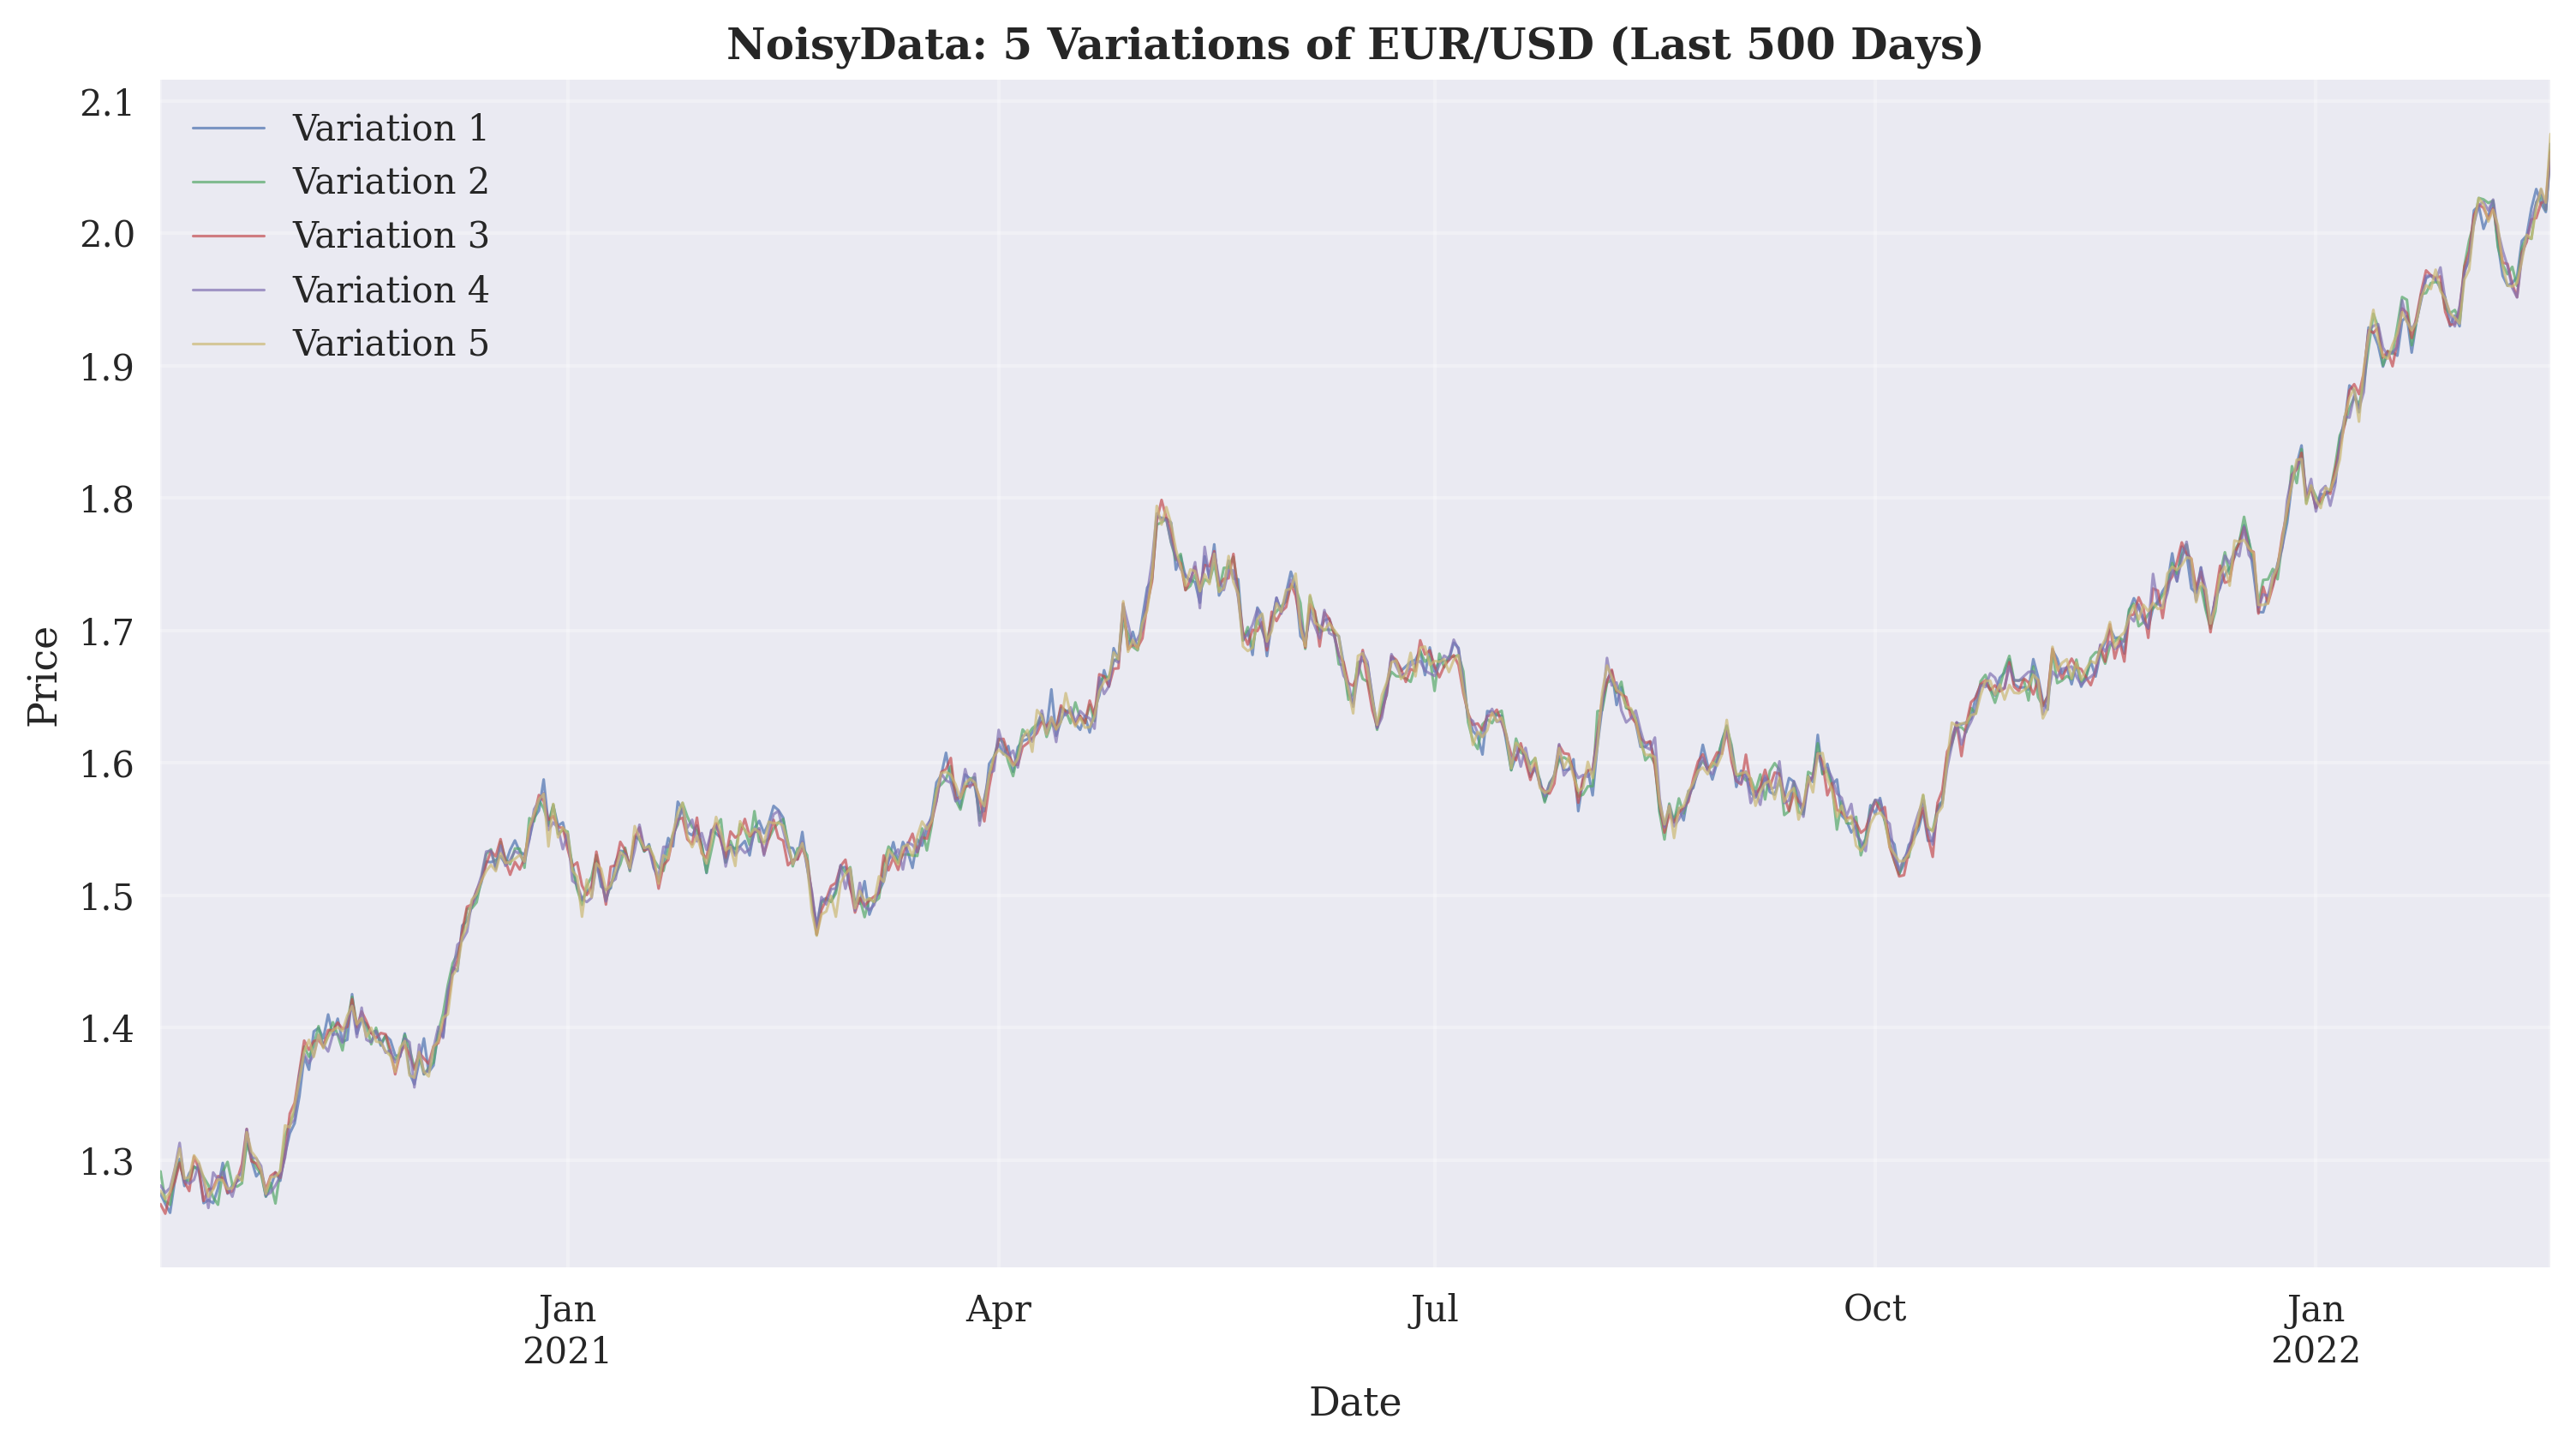

In [31]:
# Plot 5 different noisy variations
plt.figure(figsize=(12, 6))
for i in range(5):
    fin.reset()
    # Plot last 500 days instead of specific date range
    fin.data[fin.symbol].iloc[-500:].plot(lw=0.75, alpha=0.7, label=f'Variation {i+1}')
plt.title('NoisyData: 5 Variations of EUR/USD (Last 500 Days)', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Train DQL Agent on Noisy Data

In [32]:
%run dqlagent_keras3.py

In [33]:
agent = DQLAgent(fin.symbol, fin.feature, fin.n_features, fin)

In [34]:
%time agent.learn(50)

episode=  50 | treward=  6.000 | max=1360.0000
CPU times: total: 484 ms
Wall time: 2.16 s


In [35]:
agent.test(5)

total reward=2602 | accuracy=0.507
total reward=2602 | accuracy=0.511
total reward=2602 | accuracy=0.489
total reward=2602 | accuracy=0.499
total reward=2602 | accuracy=0.491



## Part 2: Monte Carlo Simulation Environment

### Simulation Environment

Generates synthetic financial data using **Ornstein-Uhlenbeck process**:

$$dX_t = \kappa(\theta - X_t)dt + \sigma X_t dW_t$$

Where:
- **κ (kappa)**: Speed of mean reversion
- **θ (theta)**: Long-term mean
- **σ (sigma)**: Volatility

**Advantages:**
- Generate unlimited scenarios
- Control market characteristics (trending, mean-reverting)
- Test in diverse conditions

In [36]:
class Simulation:
    """Monte Carlo simulation environment"""
    
    def __init__(self, symbol, feature, n_features,
                 start, end, periods,
                 min_accuracy=0.525, x0=100,
                 kappa=1, theta=100, sigma=0.2,
                 normalize=True, new=False):
        """
        Args:
            symbol: Asset symbol
            feature: Feature to use as state
            n_features: Number of lagged observations
            start, end, periods: Time series parameters
            min_accuracy: Accuracy threshold
            x0: Initial value
            kappa: Mean reversion speed
            theta: Long-term mean
            sigma: Volatility
            normalize: Whether to normalize data
            new: Generate new data on each reset
        """
        self.symbol = symbol
        self.feature = feature
        self.n_features = n_features
        self.start = start
        self.end = end
        self.periods = periods
        self.x0 = x0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.min_accuracy = min_accuracy
        self.normalize = normalize
        self.new = new
        self.action_space = ActionSpace()
        self._simulate_data()
        self._prepare_data()

In [37]:
import math

class Simulation(Simulation):
    def _simulate_data(self):
        """Simulate price path using Ornstein-Uhlenbeck process"""
        index = pd.date_range(start=self.start,
                    end=self.end, periods=self.periods)
        x = [self.x0]
        dt = (index[-1] - index[0]).days / 365 / self.periods
        
        for t in range(1, len(index)):
            # Ornstein-Uhlenbeck process
            dx = (self.kappa * (self.theta - x[t - 1]) * dt +
                  x[t - 1] * self.sigma * math.sqrt(dt) *
                  random.gauss(0, 1))
            x.append(x[t - 1] + dx)
        
        self.data = pd.DataFrame(x, columns=[self.symbol], index=index)

In [38]:
class Simulation(Simulation):
    def _prepare_data(self):
        """Prepare simulated data"""
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        
        if self.normalize:
            self.mu = self.data.mean()
            self.std = self.data.std()
            self.data_ = (self.data - self.mu) / self.std
        else:
            self.data_ = self.data.copy()
        
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data['d'] = self.data['d'].astype(int)

In [39]:
class Simulation(Simulation):
    def _get_state(self):
        return self.data_[self.feature].iloc[self.bar -
                                self.n_features:self.bar]
    
    def seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
    
    def reset(self):
        """Reset environment, optionally generating new data"""
        self.treward = 0
        self.accuracy = 0
        self.bar = self.n_features
        
        if self.new:
            self._simulate_data()
            self._prepare_data()
        
        state = self._get_state()
        return state.values, {}

In [40]:
class Simulation(Simulation):
    def step(self, action):
        """Execute action and return result"""
        if action == self.data['d'].iloc[self.bar]:
            correct = True
        else:
            correct = False
        
        reward = 1 if correct else 0
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.n_features)
        
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and self.bar > 25):
            done = True
        else:
            done = False
        
        next_state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        
        return next_state, reward, done, False, {}

### Test Simulation Environment - Different Market Regimes

In [41]:
sym = 'EUR='

In [42]:
# Baseline: No drift, no volatility
env_base = Simulation(sym, sym, 5, start='2024-1-1', end='2025-1-1',
                 periods=252, x0=1, kappa=1, theta=1.1, sigma=0.0,
                 normalize=True)

In [43]:
# Trending market: θ=2 (double starting value)
env_trend = Simulation(sym, sym, 5, start='2024-1-1', end='2025-1-1',
                 periods=252, x0=1, kappa=1, theta=2, sigma=0.1,
                 normalize=True)

In [44]:
# Mean-reverting: θ=1 (reverts to starting value)
env_mrev = Simulation(sym, sym, 5, start='2024-1-1', end='2025-1-1',
                 periods=252, x0=1, kappa=1, theta=1, sigma=0.1,
                 normalize=True)

In [45]:
env_mrev.data[sym].iloc[:3]

2024-01-02 10:59:45.657370517    0.999439
2024-01-03 21:59:31.314741035    1.001165
2024-01-05 08:59:16.972111553    0.996716
Name: EUR=, dtype: float64

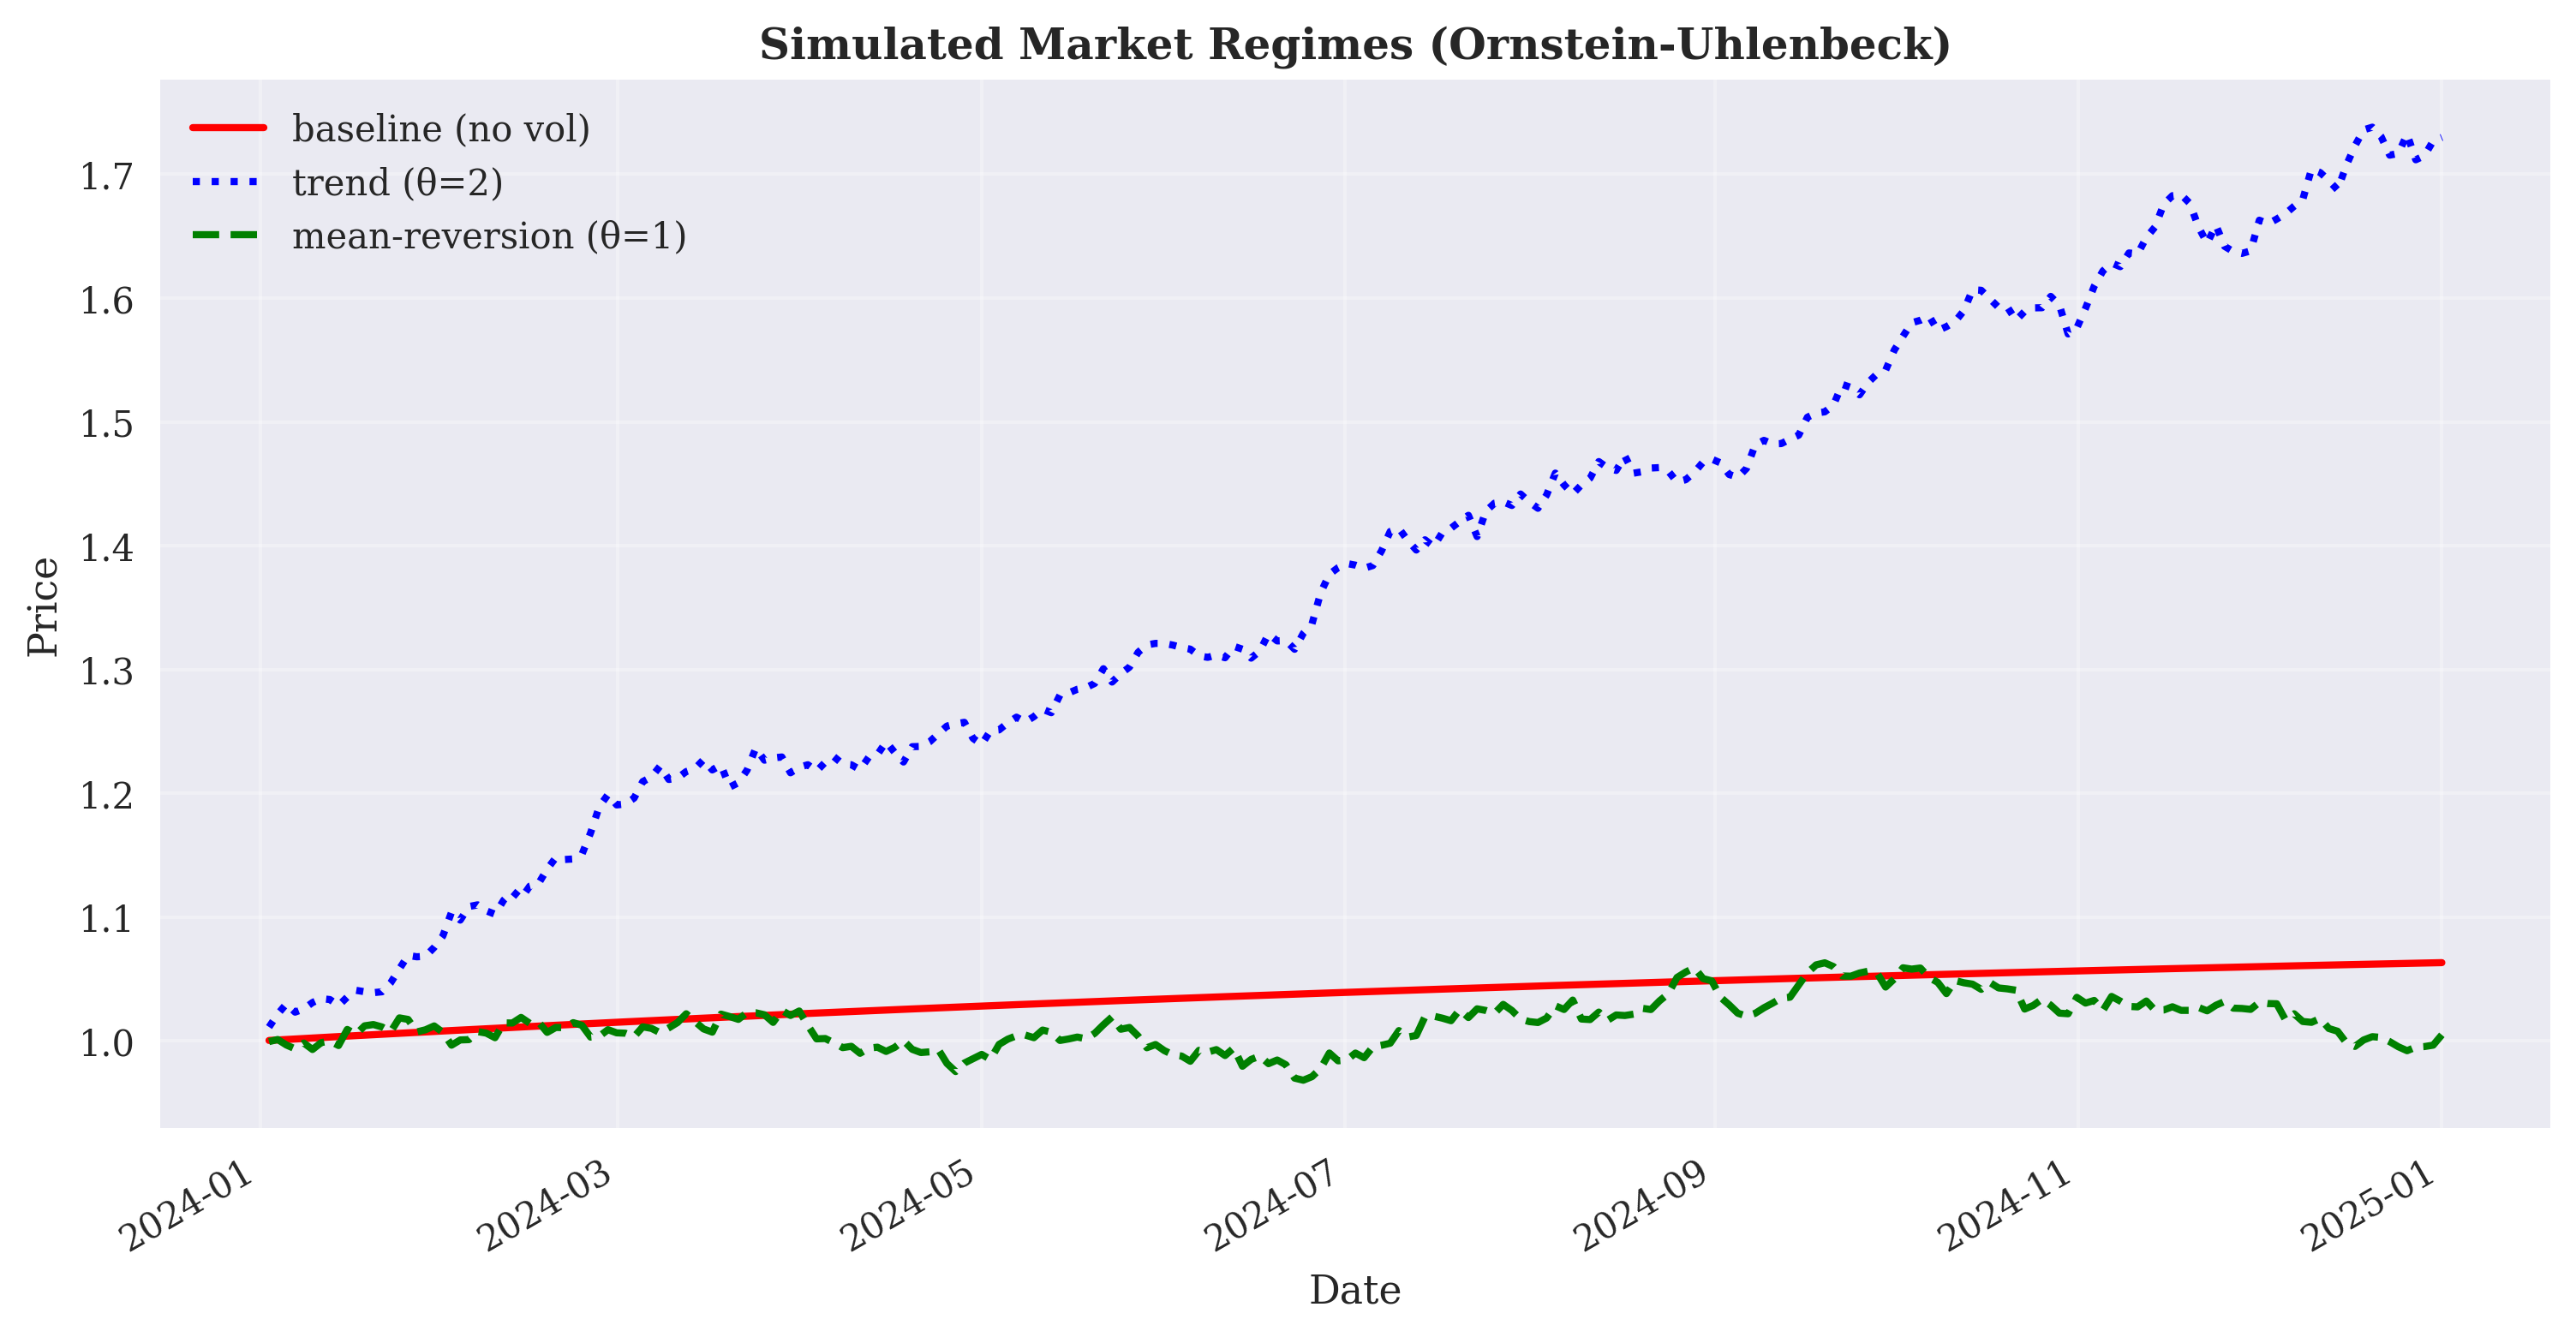

In [46]:
plt.figure(figsize=(12, 6))
env_base.data[sym].plot(label='baseline (no vol)', style='r', lw=2)
env_trend.data[sym].plot(label='trend (θ=2)', style='b:', lw=2)
env_mrev.data[sym].plot(label='mean-reversion (θ=1)', style='g--', lw=2)
plt.title('Simulated Market Regimes (Ornstein-Uhlenbeck)', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Train on Dynamic Simulations (new=True)

In [47]:
# new=True: Each reset() generates completely new time series
sim = Simulation(sym, 'r', 4, start='2024-1-1', end='2028-1-1',
                 periods=2 * 252, min_accuracy=0.485, x0=1,
                 kappa=2, theta=2, sigma=0.15,
                 normalize=True, new=True)
sim.seed(100)

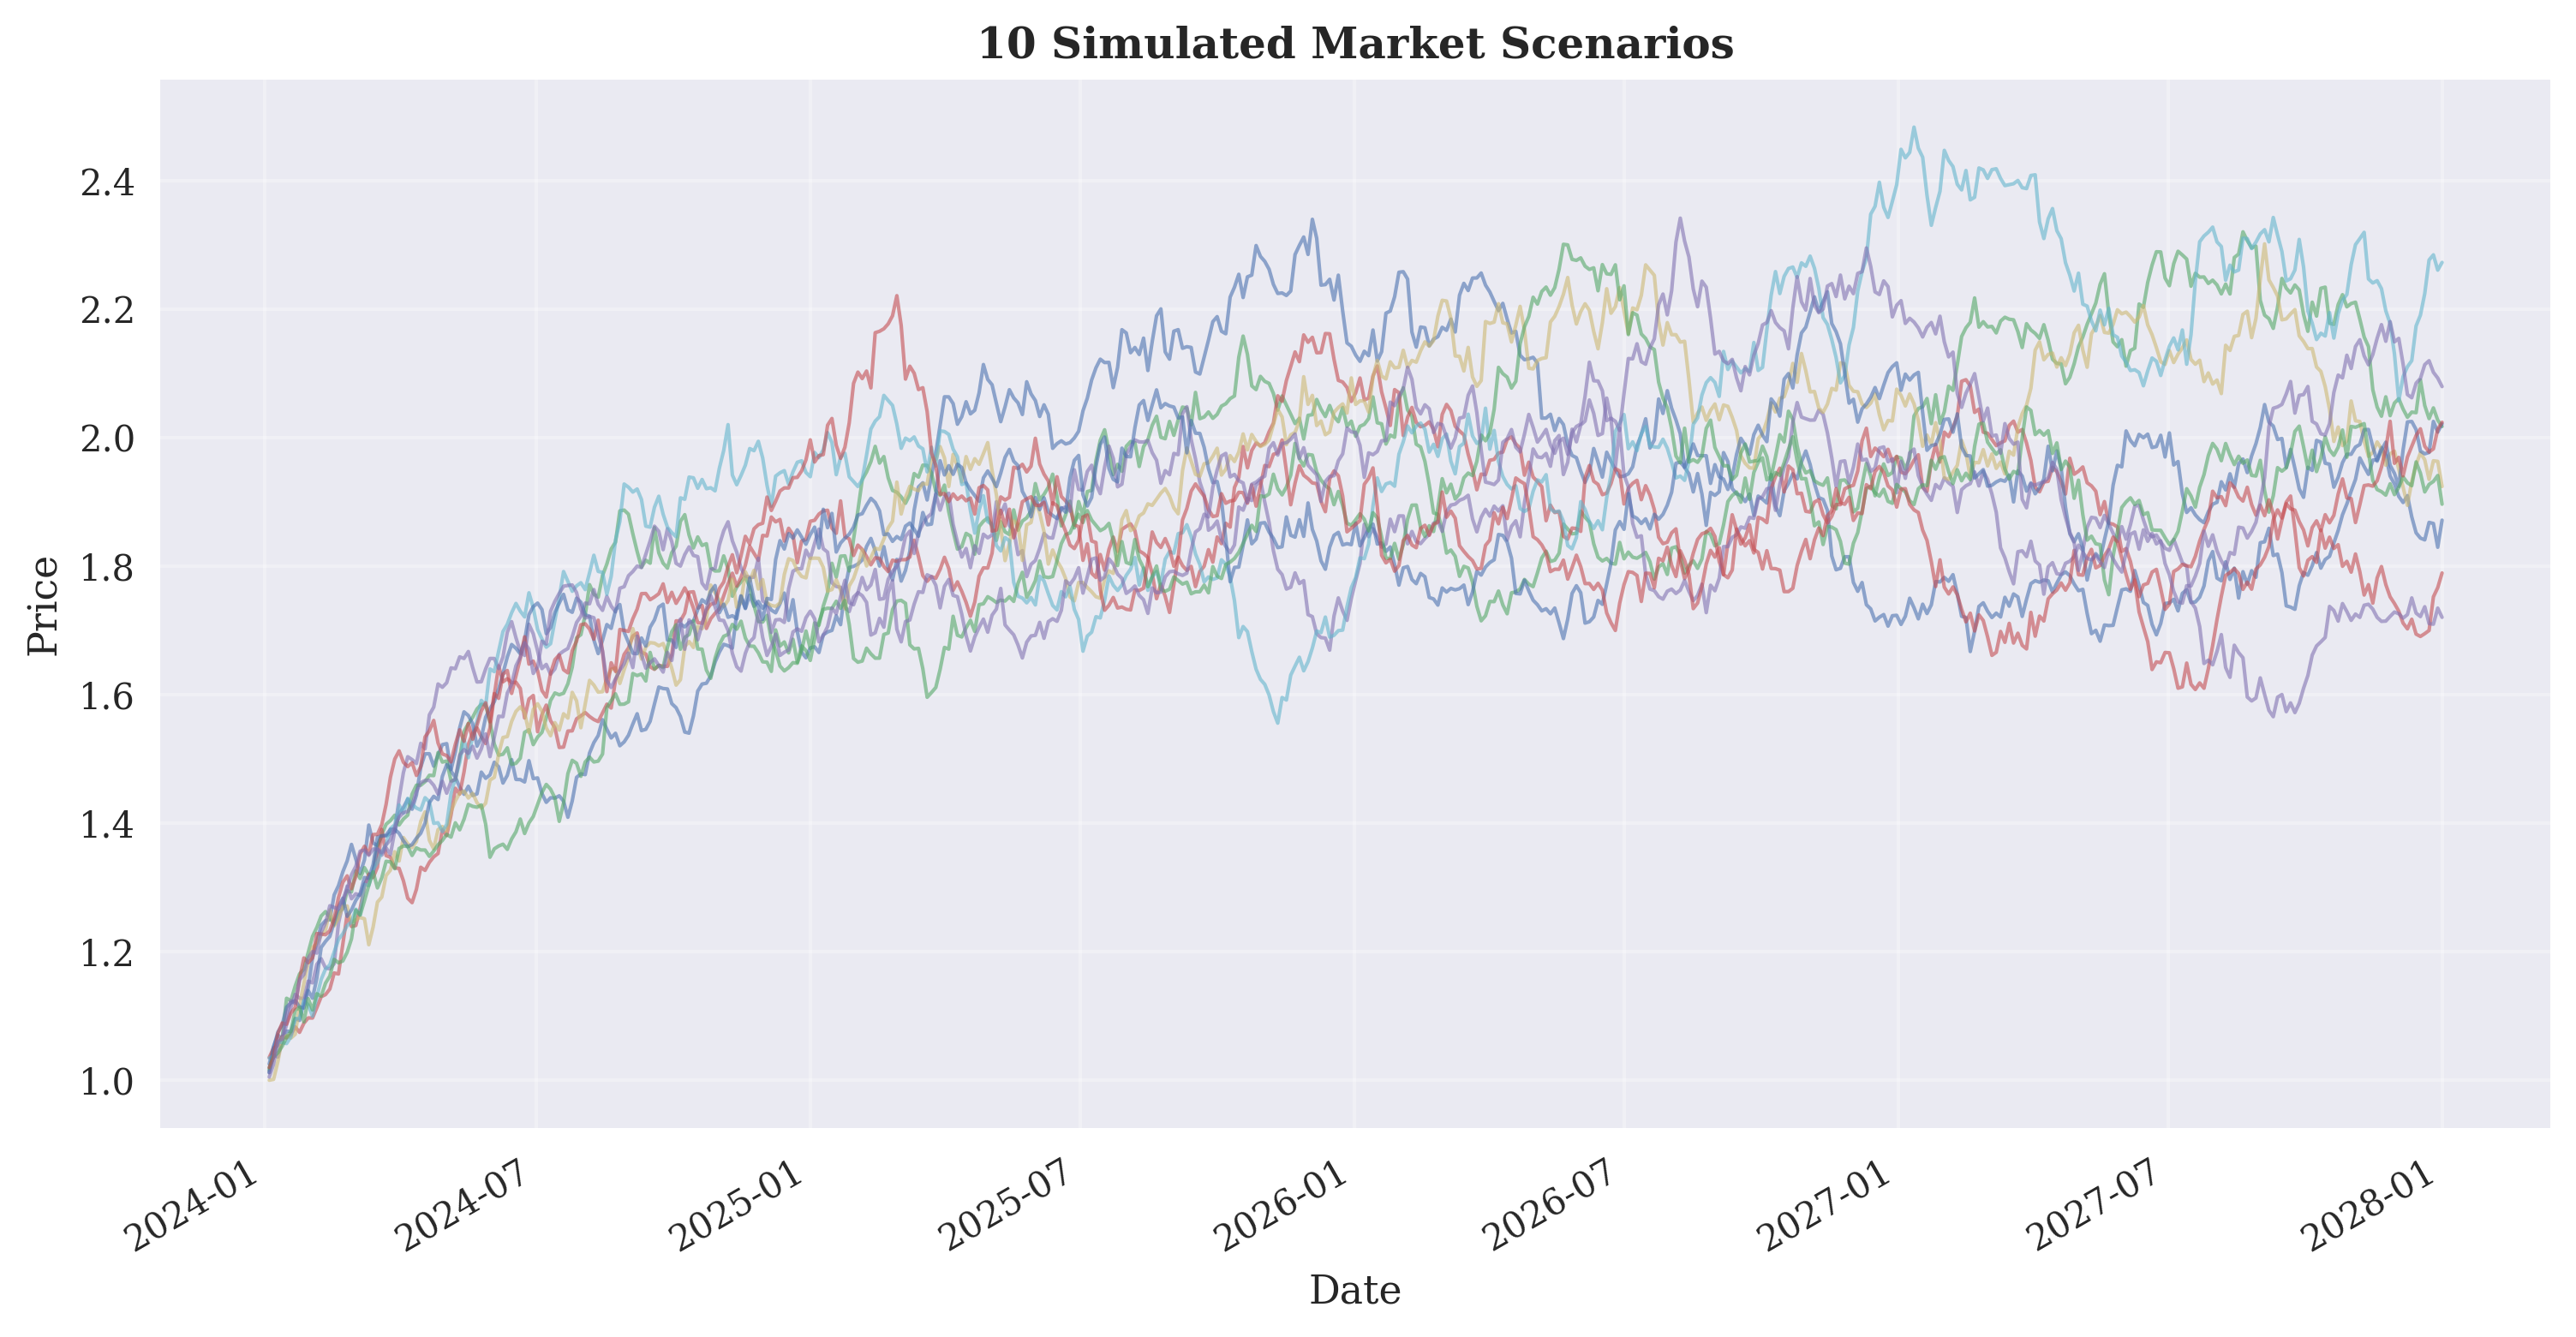

In [48]:
# Visualize 10 different simulated scenarios
plt.figure(figsize=(12, 6))
for i in range(10):
    sim.reset()
    sim.data[sym].plot(lw=1.0, alpha=0.6)
plt.title('10 Simulated Market Scenarios', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.show()

In [49]:
agent = DQLAgent(sim.symbol, sim.feature,
                 sim.n_features, sim, lr=0.0001)

In [50]:
%time agent.learn(50)

episode=  50 | treward= 30.000 | max=269.000
CPU times: total: 109 ms
Wall time: 856 ms


In [51]:
agent.test(5)

total reward= 499 | accuracy=0.513
total reward= 499 | accuracy=0.463
total reward= 499 | accuracy=0.509
total reward= 499 | accuracy=0.499
total reward= 499 | accuracy=0.537



### Train on More Challenging Scenario (Higher Accuracy Threshold)

In [52]:
# Higher accuracy requirement: 60% instead of 48.5%
sim = Simulation(sym, 'r', 4, start='2024-1-1', end='2028-1-1',
                 periods=2 * 252, min_accuracy=0.6, x0=1,
                 kappa=1.25, theta=1, sigma=0.15,
                 normalize=True, new=True)
sim.seed(100)

In [53]:
agent = DQLAgent(sim.symbol, sim.feature,
                 sim.n_features, sim, lr=0.0001)

In [54]:
# Train longer (150 episodes) for harder task
%time agent.learn(150)

episode= 150 | treward= 13.000 | max= 37.000
CPU times: total: 844 ms
Wall time: 2.11 s


In [55]:
agent.test(5)

total reward= 499 | accuracy=0.527
total reward= 499 | accuracy=0.521
total reward= 499 | accuracy=0.473
total reward= 499 | accuracy=0.501
total reward= 499 | accuracy=0.471



## Summary: Data Augmentation Benefits

### Problem Solved:
Chapter 3's limitation: "Training data limited to single, static time series"

### Solutions Demonstrated:

**1. NoisyData (White Noise Injection)**
- ✅ Easy to implement
- ✅ Generates variations from existing data
- ✅ Each episode sees different noise pattern
- ✅ Prevents memorization of exact sequence

**2. Simulation (Monte Carlo)**
- ✅ Unlimited synthetic scenarios
- ✅ Controllable market regimes (trend, mean-reversion)
- ✅ Test robustness across conditions
- ✅ No dependency on historical data availability

### For Options Hedging:
These techniques will be critical for:
- Generating diverse option scenarios (strikes, expiries, vol regimes)
- Training robust Greek estimators
- Testing hedging strategies across market conditions
- Avoiding overfitting to specific historical periods

<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>